In [240]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Imports

In [339]:

import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# import random
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk import download
# from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# print("Downloading stop-words..")
download('stopwords') # nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# create csv in desired submission format
def create_and_save_submission(predictions, file_name="submission.csv"):
    ids = [i for i in range(len(predictions))]
    sub_df = pd.DataFrame(data=list(zip(ids, predictions)), columns=["Id","Category"])
    sub_df.to_csv(file_name, index=False)
    

# evauate model score 
def evaluate_model(Model, X, y, kfold=True):
    accuracy = []

    if kfold:
        print("Evaluating model performance using k-fold...")
        
        kfold = KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
        )
        

        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            Model.fit(X_train, y_train)
            accuracy.append(Model.score(X_test, y_test))
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        Model.fit(X_train, y_train)
        accuracy.append(Model.score(X_test, y_test))
    
    return np.mean(accuracy)

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    sns.set_style("whitegrid")
    a4_dims = (12, 10)
    fig, ax = plt.subplots(figsize=a4_dims)

    sns.heatmap(cm, annot=True, ax=ax);

    plt.tight_layout()
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(labels, rotation=45);
    ax.yaxis.set_ticklabels(labels, rotation=45);

    return ax

#### Code

In [243]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    base_path = "/content/drive/My Drive/ML_data/homework_4_kaggle/"
else:
    base_path = ""

TRAIN_DATA_PATH = base_path + "data/data_train.pkl"
TEST_DATA_PATH = base_path + "data/data_test.pkl"

train_data = pd.read_pickle(TRAIN_DATA_PATH)
test_data  = pd.read_pickle(TEST_DATA_PATH)

X      = np.array(train_data[0])
y      = np.array(train_data[1])
X_test_kaggle = np.array(test_data)

All_X = np.concatenate((X, X_test_kaggle))

All_X.shape, X.shape, y.shape

((100000,), (70000,), (70000,))

In [0]:
import re 
pattern = re.compile(r'\b\w\w+\b')
stop_words_list = stopwords.words('english')

for idx, sentence in enumerate(All_X):
  #All_X[idx] = " ".join([stemmer.stem(word) for word in re.findall(pattern, sentence.lower()) if word not in stop_words_list])
  All_X[idx] = " ".join([word for word in re.findall(pattern, sentence.lower()) if word not in stop_words_list])

In [0]:
nb_X_Train = len(train_data[0])

X = All_X[:nb_X_Train]
Kaggle_Test_X = All_X[nb_X_Train:]

In [246]:
# encode y
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)
vector_Y = label_encoder.transform(y)

# encode X
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode')
vectorizer.fit(All_X)

vector_X = vectorizer.transform(X)
vector_X_test = vectorizer.transform(X_test_kaggle)

vector_X_test.shape, vector_X.shape

((30000, 88660), (70000, 88660))

In [0]:
! git clone https://github.com/facebookresearch/fastText.git
# ! wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
# ! unzip v0.9.1.zip
import os
# os.chdir('./fastText-0.9.1/')
os.chdir('./fastText/')
! make 
! pip install .
os.chdir('../')

In [0]:
import fasttext
from sklearn.utils import shuffle

In [0]:
X_shuffled, y_shuffled = shuffle(X, y)

In [0]:
with open("train.csv",mode='w+', encoding='utf8') as fout:
    for x, label in zip(X_shuffled, y_shuffled):
        fout.write(x + "\t __label__" + label + "\n")

In [0]:
# ! cat X.csv | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > X.preprocessed.csv

In [249]:
! tail -10 train.csv

client site pulling html page	 __label__leagueoflegends
lebron kicked people balls last year dray old meme find new material	 __label__nba
voice gruff sentence short mention shot jorah face really quick understood know need get mad people understand something	 __label__gameofthrones
gt wait next draft talk teams trading via sign trade duchene extends lol think duchene would ever agree extension shit like fact even suggest shows little know going even worth arguing peace	 __label__hockey
depends spec gain resources damage taken kind damage reflect technically taunt button increase dps	 __label__wow
know never gonna happen die though eventually	 __label__nba
uhhh uh jim benning got wrong number	 __label__hockey
yeah anti kesler circle jerk full force way around would noticed	 __label__hockey
fans sit seats pole sign	 __label__baseball
yepp hey check stab wounds al chest heart	 __label__gameofthrones


In [0]:
! head -n 50000 train.csv > train_data.csv
! tail -n 20000 train.csv > valid_data.csv

In [251]:
! wc train_data.csv

  50000 1175670 8469839 train_data.csv


In [0]:
os.chdir('./fastText/') # 49.205
! ./fasttext supervised -input ../train_data.csv -output ../reddit_model_ask_reddit -autotune-validation ../valid_data.csv -autotune-metric f1:__label__AskReddit
# ! ./fasttext supervised -input ../train_data.csv -output ../reddit_model -lr 0.7 -epoch 5 -wordNgrams 2 -bucket 200000 -dim 100 -loss hs
os.chdir('../')

Progress: 100.0% Trials:   11 Best score:  0.267108 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  62448
Number of labels: 20
Progress: 100.0% words/sec/thread:  265060 lr:  0.000000 avg.loss:  0.485300 ETA:   0h 0m 0s


In [0]:
os.chdir('./fastText/') # 51.985
! ./fasttext supervised -input ../train_data.csv -output ../reddit_model_conspiracy -autotune-validation ../valid_data.csv -autotune-metric f1:__label__conspiracy
# ! ./fasttext supervised -input ../train_data.csv -output ../reddit_model -lr 0.7 -epoch 5 -wordNgrams 2 -bucket 200000 -dim 100 -loss hs
os.chdir('../')

Progress:  76.7% Trials:    6 Best score:  0.387970 ETA:   0h 1m 9stcmalloc: large alloc 1980211200 bytes == 0x55afa608c000 @  0x7f579829c887 0x55af94a0375d 0x55af94a0de7e 0x55af94a158c4 0x55af949e5a71 0x55af94a1d3f4 0x55af949d8887 0x7f5797339b97 0x55af949d8b4a
Progress: 100.0% Trials:    9 Best score:  0.387970 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  62448
Number of labels: 20
Progress: 100.0% words/sec/thread:   63258 lr:  0.000000 avg.loss:  0.356450 ETA:   0h 0m 0s


In [0]:
os.chdir('./fastText/') # 48.945
! ./fasttext supervised -input ../train_data.csv -output ../reddit_model_funny -autotune-validation ../valid_data.csv -autotune-metric f1:__label__funny
# ! ./fasttext supervised -input ../train_data.csv -output ../reddit_model -lr 0.7 -epoch 5 -wordNgrams 2 -bucket 200000 -dim 100 -loss hs
os.chdir('../')

Progress:   6.8% Trials:    4 Best score:  0.211949 ETA:   0h 4m39stcmalloc: large alloc 1396473856 bytes == 0x5632b6708000 @  0x7f8b21d58887 0x563293c2d75d 0x563293c37e7e 0x563293c3f8c4 0x563293c0fa71 0x563293c473f4 0x563293c02887 0x7f8b20df5b97 0x563293c02b4a
Progress: 100.0% Trials:   14 Best score:  0.211949 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  62448
Number of labels: 20
Progress: 100.0% words/sec/thread:  462919 lr:  0.000000 avg.loss:  2.273351 ETA:   0h 0m 0s


In [0]:
os.chdir('./fastText/') # 52.01
! ./fasttext supervised -input ../train_data.csv -output ../reddit_model_europe -autotune-validation ../valid_data.csv -autotune-metric f1:__label__europe
# ! ./fasttext supervised -input ../train_data.csv -output ../reddit_model -lr 0.7 -epoch 5 -wordNgrams 2 -bucket 200000 -dim 100 -loss hs
os.chdir('../')

Progress:   6.8% Trials:    4 Best score:  0.458095 ETA:   0h 4m39stcmalloc: large alloc 1396473856 bytes == 0x5620df85a000 @  0x7f8842235887 0x5620bc25d75d 0x5620bc267e7e 0x5620bc26f8c4 0x5620bc23fa71 0x5620bc2773f4 0x5620bc232887 0x7f88412d2b97 0x5620bc232b4a
Progress: 100.0% Trials:    8 Best score:  0.472617 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  62448
Number of labels: 20
Progress: 100.0% words/sec/thread:  300645 lr:  0.000000 avg.loss:  0.166024 ETA:   0h 0m 0s


In [0]:
os.chdir('./fastText/') # 51.34
! ./fasttext supervised -input ../train_data.csv -output ../reddit_model_world_news -autotune-validation ../valid_data.csv -autotune-metric f1:__label__worldnews
# ! ./fasttext supervised -input ../train_data.csv -output ../reddit_model -lr 0.7 -epoch 5 -wordNgrams 2 -bucket 200000 -dim 100 -loss hs
os.chdir('../')

Progress: 100.0% Trials:   11 Best score:  0.325434 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  62448
Number of labels: 20
Progress: 100.0% words/sec/thread:  370865 lr:  0.000000 avg.loss:  0.451108 ETA:   0h 0m 0s


In [0]:
with open("valid_data.csv") as fin:
    data =  fin.readlines()

data = [line.rstrip('\n') for line in data]

In [0]:
with open("train_data.csv") as fin:
    data_X =  fin.readlines()

data_X = [line.rstrip('\n') for line in data_X]

In [0]:
data_X_ = []
data_y_ = []
for j in range(len(data_X)):
    p,q = data_X[j].split("__label__")[0][:-2], data_X[j].split("__label__")[1]
    data_X_.append(p)
    data_y_.append(q)

In [0]:
vector_data_X = vectorizer.transform(data_X_)

In [252]:
mnb_clf = MultinomialNB(alpha=0.25)
mnb_clf.fit(vector_data_X, label_encoder.transform(data_y_))

MultinomialNB(alpha=0.25, class_prior=None, fit_prior=True)

In [253]:
mnb_clf.score(vectorizer.transform(data), label_encoder.transform(y_true))

0.565

In [318]:
from collections import Counter
# Counter(y_pred).most_common(1)[0][0]

'movies'

In [0]:
# crude approach - last effort! :/

#  using max prob
from tqdm import tqdm_notebook as tqdm

# merged model
y_pred = []
y_true = []

g_model = fasttext.load_model("reddit_model.bin")
f_model = fasttext.load_model("reddit_model_funny.bin")
e_model = fasttext.load_model("reddit_model_europe.bin")
w_model = fasttext.load_model("reddit_model_world_news.bin")
c_model = fasttext.load_model("reddit_model_conspiracy.bin")
a_model = fasttext.load_model("reddit_model_ask_reddit.bin")

models = [g_model, f_model, e_model, w_model, c_model, a_model, mnb_clf]

weak = ['funnny','europe','worldnews','conspiracy','AskReddit']
for i in tqdm(range(len(data))):
    line = data[i]
    test = line.split("__label__")[0]
    pred = label_encoder.inverse_transform([mnb_clf.predict(vectorizer.transform([test]))[0]])
    # g = list(g_model.predict(test))[0][0][9:]
    if pred in weak:
        pred_ = np.max(mnb_clf.predict_proba(vectorizer.transform([test])))
        g = list(g_model.predict(test))[1][0]
        f = list(f_model.predict(test))[1][0]
        e = list(e_model.predict(test))[1][0]
        w = list(w_model.predict(test))[1][0]
        c = list(c_model.predict(test))[1][0]
        a = list(a_model.predict(test))[1][0]

        clf = [g,f,e,w,c,a,pred_]
        n_models = len(clf)
        model_index = clf.index(max(clf))

        if model_index != n_models - 1:
            pred = models[model_index].predict(test)[0][0][9:]

    if type(pred) == np.ndarray:
        y_pred.append(pred[0])
    else:
        y_pred.append(pred)

    y_true.append(line.split("__label__")[1])

accuracy_score(y_true, y_pred)

In [0]:
# crude apprioach - last effort! :/

# inference
from tqdm import tqdm_notebook as tqdm

# merged model
y_pred = []
y_true = []

g_model = fasttext.load_model("reddit_model.bin")
f_model = fasttext.load_model("reddit_model_funny.bin")
e_model = fasttext.load_model("reddit_model_europe.bin")
w_model = fasttext.load_model("reddit_model_world_news.bin")
c_model = fasttext.load_model("reddit_model_conspiracy.bin")
a_model = fasttext.load_model("reddit_model_ask_reddit.bin")

models = [g_model, f_model, e_model, w_model, c_model, a_model, mnb_clf]

weak = ['funnny','europe','worldnews','conspiracy','AskReddit']
for i in tqdm(range(len(Kaggle_Test_X))):
    line = data[i]
    test = line.split("__label__")[0]
    pred = label_encoder.inverse_transform([mnb_clf.predict(vectorizer.transform([test]))[0]])
    # g = list(g_model.predict(test))[0][0][9:]
    if pred in weak:
        pred_ = np.max(mnb_clf.predict_proba(vectorizer.transform([test])))
        g = list(g_model.predict(test))[1][0]
        f = list(f_model.predict(test))[1][0]
        e = list(e_model.predict(test))[1][0]
        w = list(w_model.predict(test))[1][0]
        c = list(c_model.predict(test))[1][0]
        a = list(a_model.predict(test))[1][0]

        clf = [g,f,e,w,c,a,pred_]
        n_models = len(clf)
        model_index = clf.index(max(clf))

        if model_index != n_models - 1:
            pred = models[model_index].predict(test)[0][0][9:]

    if type(pred) == np.ndarray:
        y_pred.append(pred[0])
    else:
        y_pred.append(pred)

    # y_true.append(line.split("__label__")[1])

# accuracy_score(y_true, y_pred)

In [337]:
# report class predicted by maximum clfs

from tqdm import tqdm_notebook as tqdm

# merged model
y_pred = []
y_true = []

g_model = fasttext.load_model("reddit_model.bin")
f_model = fasttext.load_model("reddit_model_funny.bin")
e_model = fasttext.load_model("reddit_model_europe.bin")
w_model = fasttext.load_model("reddit_model_world_news.bin")
c_model = fasttext.load_model("reddit_model_conspiracy.bin")
a_model = fasttext.load_model("reddit_model_ask_reddit.bin")

models = [g_model, f_model, e_model, w_model, c_model, a_model, mnb_clf]

weak = ['funnny','europe','worldnews','conspiracy','AskReddit']
for i in tqdm(range(len(data))):
    line = data[i]
    test = line.split("__label__")[0]
    pred = label_encoder.inverse_transform([mnb_clf.predict(vectorizer.transform([test]))[0]])[0]
    # g = list(g_model.predict(test))[0][0][9:]
    if pred in weak:
        g = list(g_model.predict(test))[0][0][9:]
        f = list(f_model.predict(test))[0][0][9:]
        e = list(e_model.predict(test))[0][0][9:]
        w = list(w_model.predict(test))[0][0][9:]
        c = list(c_model.predict(test))[0][0][9:]
        a = list(a_model.predict(test))[0][0][9:]

        clf = [g,f,e,w,c,a,pred]
        if Counter(clf).most_common(1)[0][1] > 1:
            pred = Counter(clf).most_common(1)[0][0]

    y_pred.append(pred)
    y_true.append(line.split("__label__")[1])

accuracy_score(y_true, y_pred)

0.56495

In [421]:
# report class predicted by maximum clfs
import operator

from tqdm import tqdm_notebook as tqdm

# merged model
y_pred = []
y_true = []

g_model = fasttext.load_model("reddit_model.bin")
f_model = fasttext.load_model("reddit_model_funny.bin")
e_model = fasttext.load_model("reddit_model_europe.bin")
w_model = fasttext.load_model("reddit_model_world_news.bin")
c_model = fasttext.load_model("reddit_model_conspiracy.bin")
a_model = fasttext.load_model("reddit_model_ask_reddit.bin")

models = [g_model, f_model, e_model, w_model, c_model, a_model, mnb_clf]

weak = ['funnny','europe','worldnews','conspiracy','AskReddit']
for i in tqdm(range(len(data))):
    line = data[i]
    test = line.split("__label__")[0]
    c = Counter()
    p = {k:v for k,v in zip(label_encoder.classes_, mnb_clf.predict_proba(vectorizer.transform([test]))[0])}
    c.update(p)
    for model in models[:len(models)-1]:
        p = model.predict(test, k=20)
        c.update({k[9:]:v for k,v in zip(p[0], p[1])})

    pred = max(c.items(), key=operator.itemgetter(1))[0]

    y_pred.append(pred)
    y_true.append(line.split("__label__")[1])

accuracy_score(y_true, y_pred)

0.5407

In [0]:
create_and_save_submission(y_pred, file_name="merged.csv")

In [0]:
# os.chdir('./fastText/')
# ! ./fasttext test ../reddit_model.bin ../valid_data.csv
# os.chdir('../')

In [343]:
model = fasttext.load_model("reddit_model.bin")
# model = fasttext.load_model("reddit_model_world_news.bin")
# model = fasttext.load_model("reddit_model_conspiracy.bin")
# model = fasttext.load_model("reddit_model_europe.bin")
# model = fasttext.load_model("reddit_model_funny.bin")
# model = fasttext.load_model("reddit_model_ask_reddit.bin")

In [344]:
y_pred = []
y_true = []
for line in data:
    test = line.split("__label__")[0]
    pred = list(model.predict(test))[0][0][9:]
    y_pred.append(pred)
    y_true.append(line.split("__label__")[1])

accuracy_score(y_true, y_pred)

0.5191

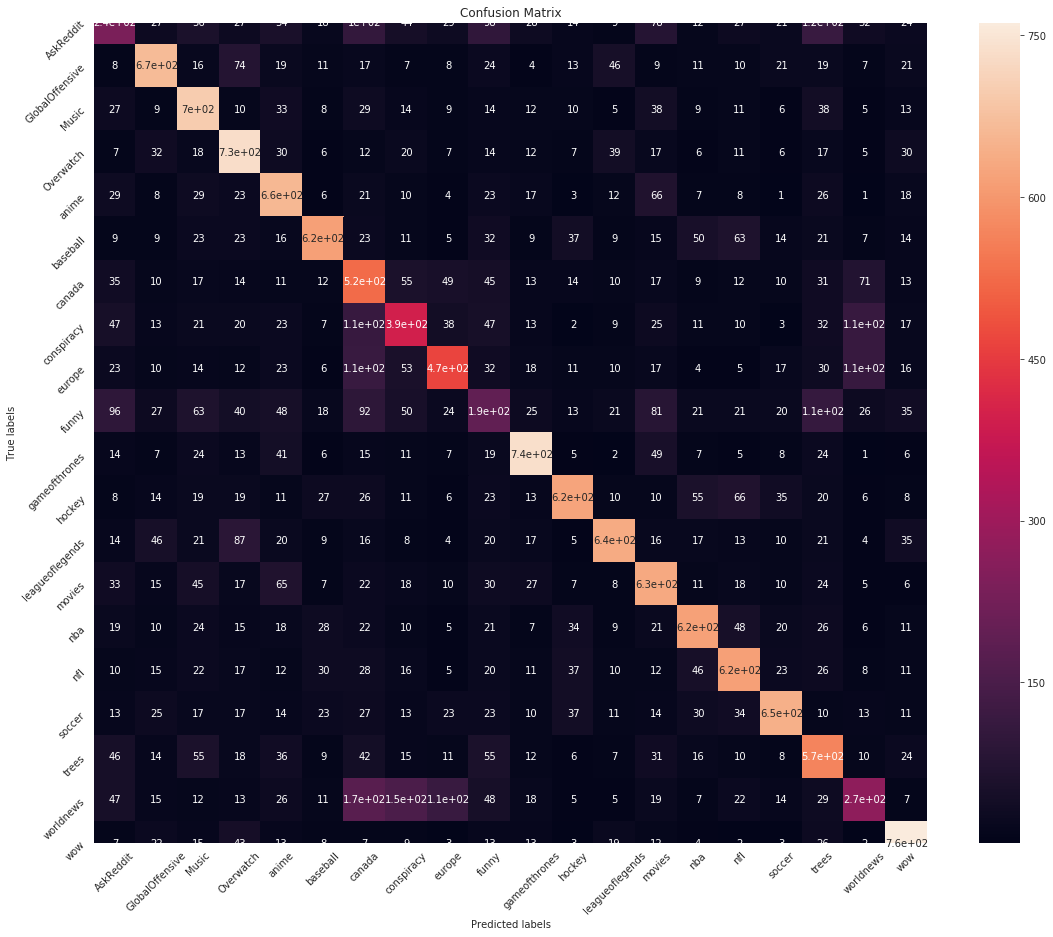

In [341]:
labels = label_encoder.classes_

plot_confusion_matrix(y_true, y_pred, labels)

In [0]:
index = 400
pred = model.predict(data[index], k=3)
pred, y_true[index], data[index]

((('__label__hockey', '__label__trees', '__label__AskReddit'),
  array([0.4651798 , 0.32840055, 0.1033121 ])),
 'hockey',
 'give little insight dislike detroits new equipment understand\t __label__hockey')